In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import os

In [2]:
dataset_dir = 'D:\\Eye\\Eye Research\\Dataset Collected\\CCN'

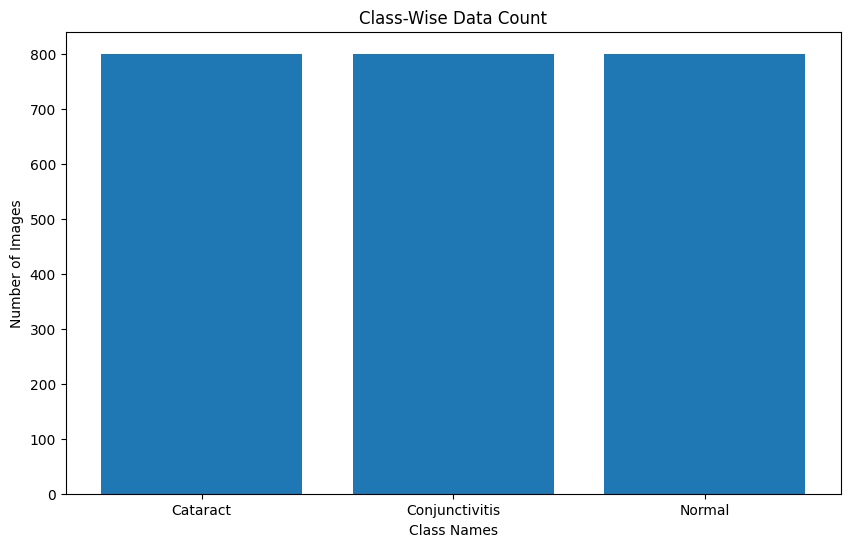

In [3]:
class_counts = {}
for subdir, dirs, files in os.walk(dataset_dir):
    for dir in dirs:
        class_counts[dir] = len(os.listdir(os.path.join(subdir, dir)))

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class-Wise Data Count')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.show()

In [5]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 2160 images belonging to 3 classes.
Found 240 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.


In [6]:
def plot_images(generator, title):
    sample_images, _ = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(sample_images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

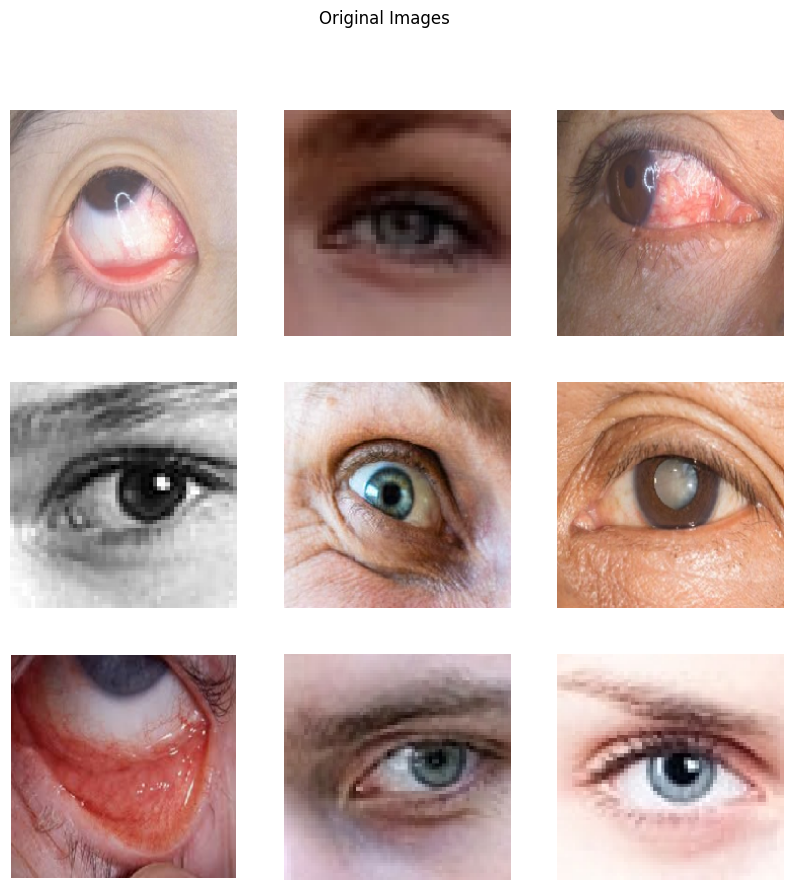

In [7]:
plot_images(train_generator, "Original Images")

Found 2400 images belonging to 3 classes.


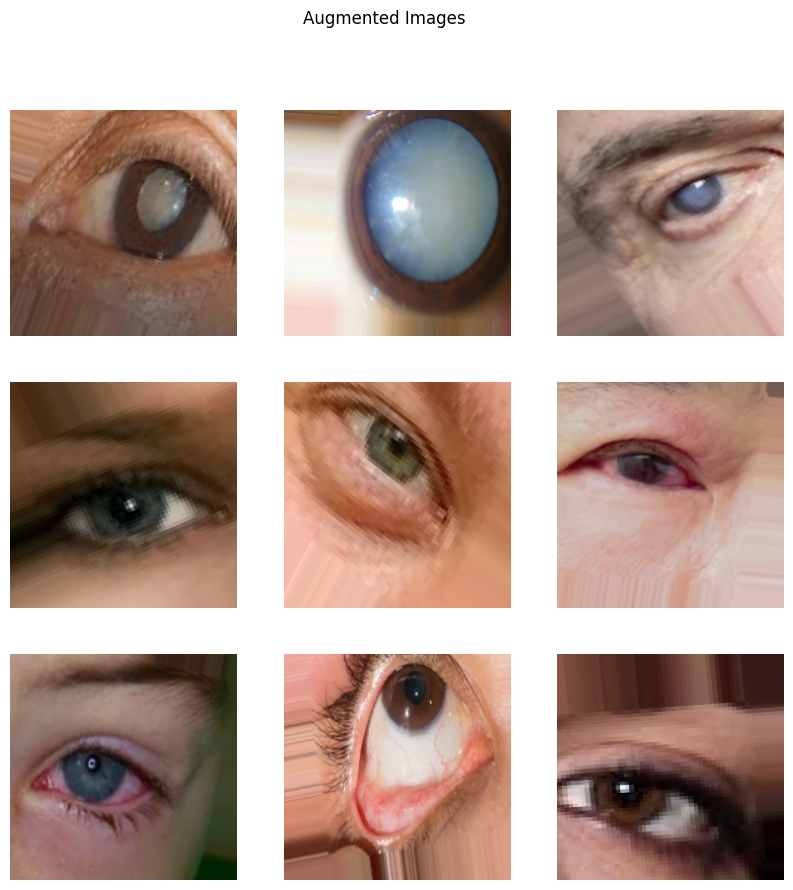

In [8]:
plot_images(augmented_datagen.flow_from_directory(dataset_dir, target_size=(224, 224), batch_size=32, class_mode='sparse', subset='training'), "Augmented Images")

In [9]:
def create_xception_model(input_shape=(224, 224, 3), num_classes=3):
    xception_base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in xception_base.layers:
        layer.trainable = False

    x = Flatten()(xception_base.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=xception_base.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
def generator_to_numpy(generator):
    images = []
    labels = []
    for _ in range(len(generator)):
        img, lbl = next(generator)
        images.append(img)
        labels.append(lbl)
    return np.concatenate(images), np.concatenate(labels)

X, y = generator_to_numpy(train_generator)

In [11]:
def calculate_metrics(conf_matrix):
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.sum() - (FP + FN + TP)

    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)

    return TPR, TNR, FPR, FNR

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
accuracies = []
histories = []
tpr_list = []
tnr_list = []
fpr_list = []
fnr_list = []

for train_index, val_index in kf.split(X):
    print(f"Training fold {fold_no}...")
    
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_xception_model()

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
    histories.append(history)

    y_val_pred = model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    conf_matrix = confusion_matrix(y_val, y_val_pred_classes)
    class_report = classification_report(y_val, y_val_pred_classes, target_names=list(class_counts.keys()))

    TPR, TNR, FPR, FNR = calculate_metrics(conf_matrix)

    tpr_list.append(TPR)
    tnr_list.append(TNR)
    fpr_list.append(FPR)
    fnr_list.append(FNR)

    print(f"Fold {fold_no} - Classification Report:\n{class_report}")
    print(f"Fold {fold_no} - Confusion Matrix:\n{conf_matrix}")
    print(f"Fold {fold_no} - TPR: {TPR}")
    print(f"Fold {fold_no} - TNR: {TNR}")
    print(f"Fold {fold_no} - FPR: {FPR}")
    print(f"Fold {fold_no} - FNR: {FNR}")

    accuracies.append(history.history['val_accuracy'][-1])

    fold_no += 1

Training fold 1...
Epoch 1/20


54/54 [==============================] - 489s 9s/step - loss: 0.6369 - accuracy: 0.8351 - val_loss: 0.1598 - val_accuracy: 0.9329
Epoch 2/20
54/54 [==============================] - 457s 9s/step - loss: 0.1883 - accuracy: 0.9329 - val_loss: 0.1285 - val_accuracy: 0.9606
Epoch 3/20
54/54 [==============================] - 584s 11s/step - loss: 0.1055 - accuracy: 0.9653 - val_loss: 0.0889 - val_accuracy: 0.9537
Epoch 4/20
54/54 [==============================] - 614s 11s/step - loss: 0.0824 - accuracy: 0.9711 - val_loss: 0.0879 - val_accuracy: 0.9653
Epoch 5/20
54/54 [==============================] - 501s 9s/step - loss: 0.0676 - accuracy: 0.9803 - val_loss: 0.0719 - val_accuracy: 0.9769
Epoch 6/20
54/54 [==============================] - 615s 11s/step - loss: 0.0342 - accuracy: 0.9890 - val_loss: 0.0983 - val_accuracy: 0.9630
Epoch 7/20
54/54 [==============================] - 455s 9s/step - loss: 0.0243 - accuracy: 0.9925 - val_loss: 0.0808 - val_accura

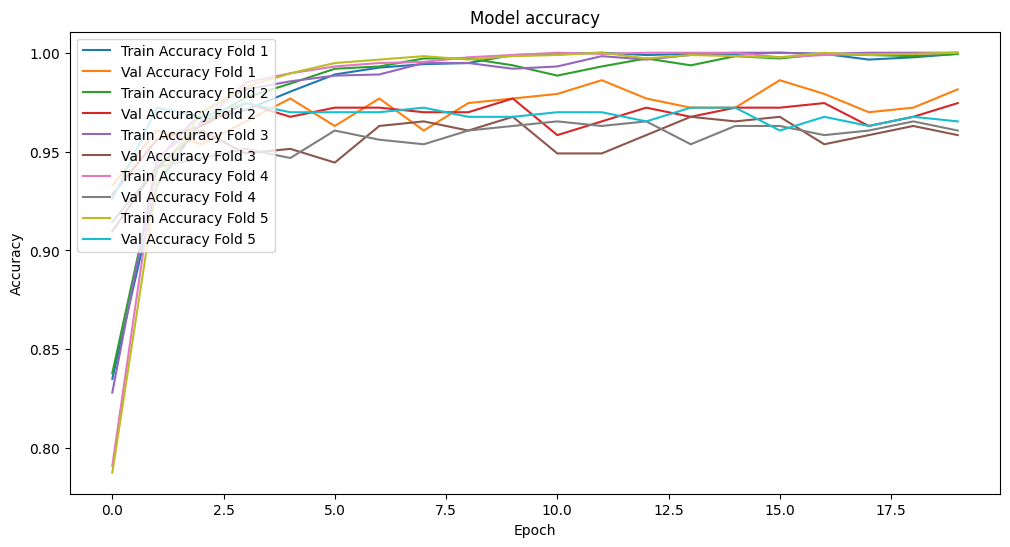

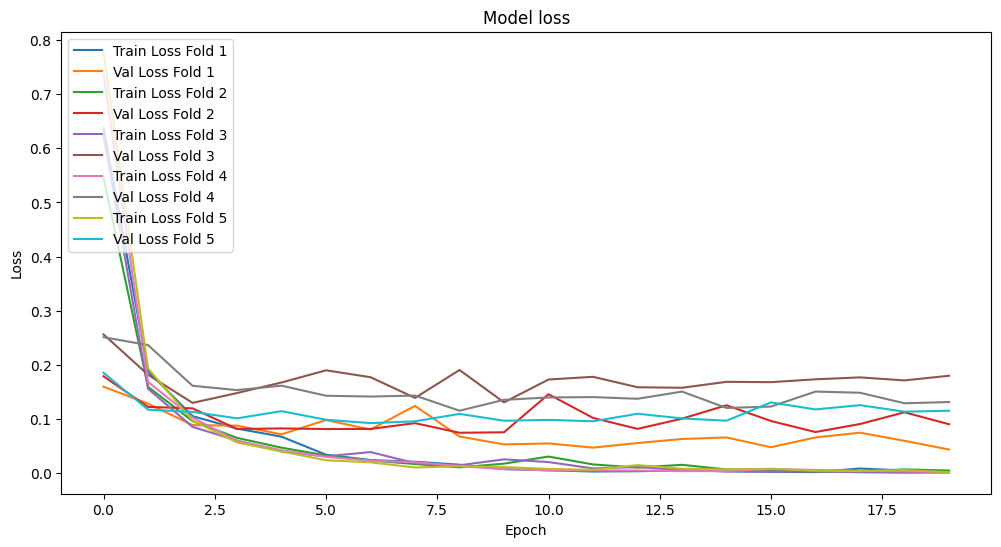

Average Validation Accuracy: 0.9680555462837219
Validation Accuracies for each fold: [0.9814814925193787, 0.9745370149612427, 0.9583333134651184, 0.9606481194496155, 0.9652777910232544]
Average TPR: [0.98630175 0.95514105 0.96318474]
Average TNR: [0.97947409 0.98599557 0.98664552]
Average FPR: [0.02052591 0.01400443 0.01335448]
Average FNR: [0.01369825 0.04485895 0.03681526]
76/76 [==============================] - 117s 2s/step
Test Classification Report:
                precision    recall  f1-score   support

      Cataract       0.99      1.00      0.99       800
Conjunctivitis       0.99      0.99      0.99       800
        Normal       0.99      0.99      0.99       800

      accuracy                           0.99      2400
     macro avg       0.99      0.99      0.99      2400
  weighted avg       0.99      0.99      0.99      2400

Test Confusion Matrix:
[[797   2   1]
 [  3 791   6]
 [  4   2 794]]
Test TPR: [0.99625 0.98875 0.9925 ]
Test TNR: [0.995625 0.9975   0.995625]
T

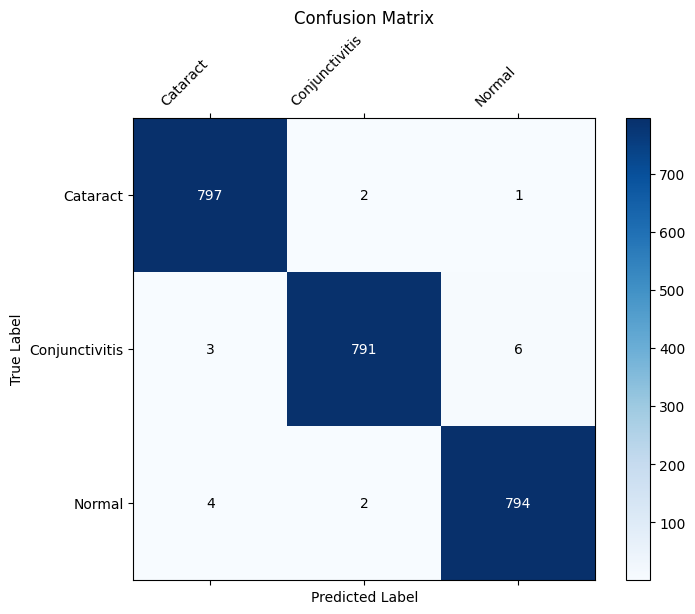

In [15]:
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Train Accuracy Fold {i+1}')
    plt.plot(history.history['val_accuracy'], label=f'Val Accuracy Fold {i+1}')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Loss Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Val Loss Fold {i+1}')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

print(f"Average Validation Accuracy: {np.mean(accuracies)}")
print(f"Validation Accuracies for each fold: {accuracies}")

avg_tpr = np.mean(tpr_list, axis=0)
avg_tnr = np.mean(tnr_list, axis=0)
avg_fpr = np.mean(fpr_list, axis=0)
avg_fnr = np.mean(fnr_list, axis=0)

print(f"Average TPR: {avg_tpr}")
print(f"Average TNR: {avg_tnr}")
print(f"Average FPR: {avg_fpr}")
print(f"Average FNR: {avg_fnr}")

best_fold = np.argmax(accuracies)
best_model = histories[best_fold].model

test_generator.reset()
y_test = test_generator.classes
y_test_pred = best_model.predict(test_generator, steps=test_generator.n // test_generator.batch_size + 1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

conf_matrix_test = confusion_matrix(y_test, y_test_pred_classes)
class_report_test = classification_report(y_test, y_test_pred_classes, target_names=list(class_counts.keys()))

print(f"Test Classification Report:\n{class_report_test}")
print(f"Test Confusion Matrix:\n{conf_matrix_test}")

TPR_test, TNR_test, FPR_test, FNR_test = calculate_metrics(conf_matrix_test)
print(f"Test TPR: {TPR_test}")
print(f"Test TNR: {TNR_test}")
print(f"Test FPR: {FPR_test}")
print(f"Test FNR: {FNR_test}")

def plot_confusion_matrix(cm, class_names):
    """
    Plots the confusion matrix.
    Args:
        cm: confusion matrix
        class_names: list of class names
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix_test, list(class_counts.keys()))